In [1]:
# CODE BLOCK 1 - Importing helpful libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pylab import rcParams
import statistics as stat
import numpy as np

plt.rcParams["figure.figsize"] = (25,12.5)

In [2]:
# CODE BLOCK 2 - Web Scraping 

# Enter the website and use BeautifulSoup to parse it as HTML
page = requests.get('http://www.espn.com/mlb/history/leaders/_/breakdown/season/year/2019/start/1')
soup = BeautifulSoup(page.text, 'html.parser')

# Learning how to get data for a single player using BeautifulSoup
row = soup.find('tr', attrs = {'class': 'oddrow player-10-6524'})
for data in row.find_all('td'):
    print(data.get_text())


1
Howie Kendrick
14
121
334
61
115
23
1
17
62
27
49
2
1
.344


In [3]:
# CODE BLOCK 3 - Create dataframe

# Finding the appropriate headers and creating a final pandas dataframe
header = soup.find('tr', attrs={'class': 'colhead'})
columns = [col.get_text() for col in header.find_all('td')]

final_df = pd.DataFrame(columns = columns)
final_df

# In this for loop we will go through all the pages to get all of the players in the MLB. Each webpage holds 50 
# players at a time thus the reason for stepping by 50 and using string formatting in the website. I also used regular 
# expression to handle the HTML format and isolate the player id number. 
for i in range(1,346,50):
    
    website = 'http://www.espn.com/mlb/history/leaders/_/breakdown/season/year/2019/start/{}'.format(i)
    page = requests.get(website)
    soup = BeautifulSoup(page.text, 'html.parser')

    players = soup.find_all('tr', attrs={'class' : re.compile('row player-10-')})
    for player in players:

        stats = [stat.get_text() for stat in player.find_all('td')]

        temp_df = pd.DataFrame(stats).transpose()
        temp_df.columns = columns

        final_df = pd.concat([final_df, temp_df], ignore_index = True)

final_df

# Covert to a csv file
# final_df.to_csv(r"mlb_hitting2019.csv", sep= ',', encoding = 'utf-8')


,,PLAYER,YRS,G,AB,R,H,2B,3B,HR,RBI,BB,SO,SB,CS,BA
0,1,Howie Kendrick,14,121,334,61,115,23,1,17,62,27,49,2,1,.344
1,2,Tim Anderson,4,123,498,81,167,32,0,18,56,15,109,17,5,.335
2,3,Luis Arraez,1,92,326,54,109,20,1,4,28,36,29,2,2,.334
3,4,Donovan Solano,6,81,215,27,71,13,1,4,23,10,49,0,1,.330
4,5,Christian Yelich,7,130,489,100,161,29,3,44,97,80,118,30,2,.329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,342,Lewis Brinson,3,75,226,15,39,9,1,0,15,13,74,1,1,.173
342,343,Keon Broxton,5,100,204,24,34,4,0,6,16,20,104,10,6,.167
343,344,Mike Zunino,7,90,266,30,44,10,1,9,32,20,98,0,0,.165
344,345,Jeff Mathis,15,86,228,17,36,9,0,2,12,15,87,1,0,.158


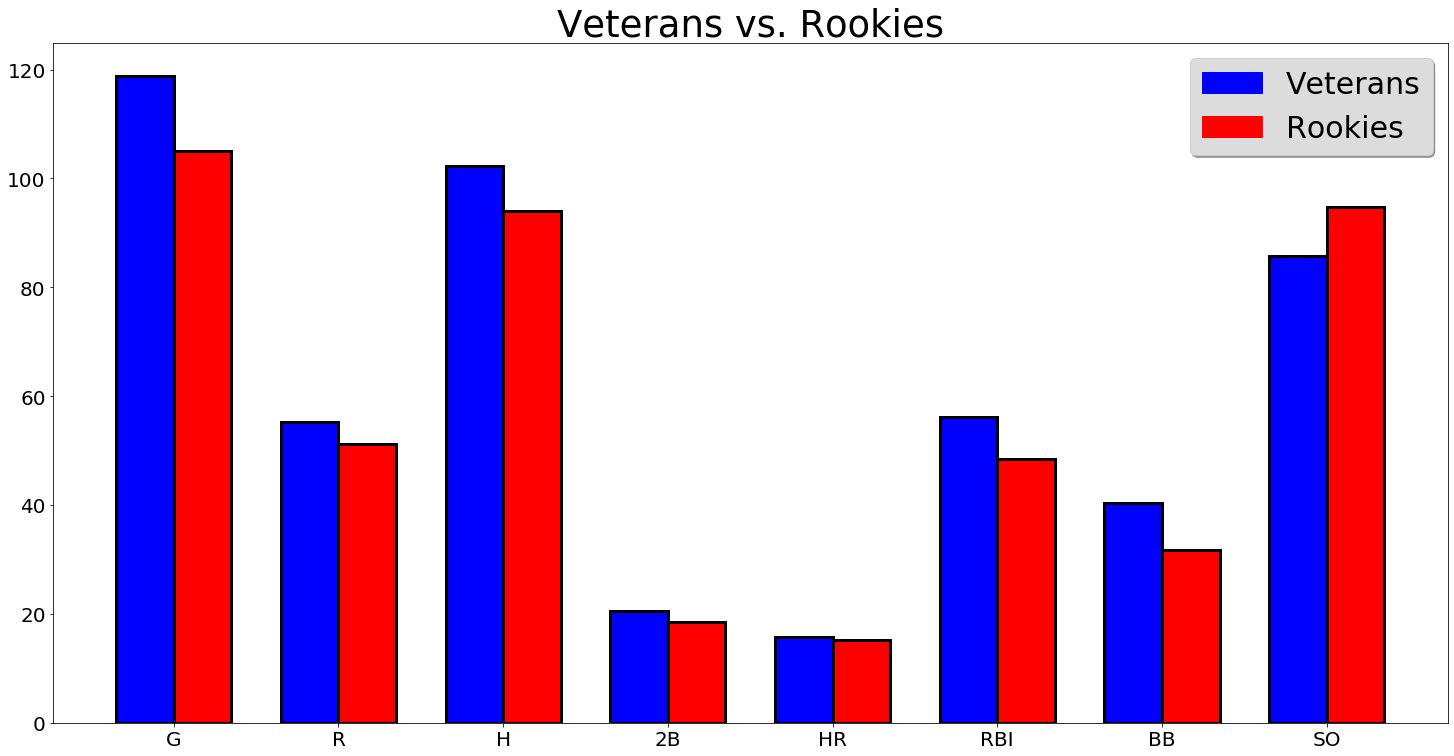

In [4]:
# Code Block 4 - Start telling a story 

# Convert the data to the appropriate data type 
stats = ['YRS', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'BB', 'SO', 'SB', 'CS', 'BA']
for stat in stats:
    if(stat == 'BA'):
        final_df['BA'] = final_df['BA'].astype(float)
    else:
        final_df[stat] = final_df[stat].astype(int)

# Create smaller data frames:
# Veterans: Players with 10+ years in the league (55 players)
# Rookies: Players in their first or second year in the league (61 players)
veterans = final_df[final_df['YRS'] > 9]
rookies = final_df[final_df['YRS'] < 3]


# Removed a handful of stats that had low values so that barplot would scale properly 
g1stats = ['G', 'R', 'H', '2B', 'HR','RBI', 'BB', 'SO']

# Create lists of the average values for each statistic to be used in a barchart 
vetMeans = []
rokMeans = []
for stat in g1stats:
    vetMeans.append(veterans[stat].mean())
    rokMeans.append(rookies[stat].mean())

# Vizualize the chosen statistics side by side in order to compare Veterans against Rookies    
x = np.arange(len(g1stats))  
width = 0.35  
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, vetMeans, width, label='Veterans', color = 'blue', edgecolor = 'black', linewidth = 3)
rects2 = ax.bar(x + width/2, rokMeans, width, label='Rookies', color = 'red', edgecolor = 'black', linewidth = 3)

plt.title("Veterans vs. Rookies", size = 37)
ax.set_xticks(x)
ax.set_xticklabels(g1stats,size= 20)
ax.set_yticklabels(labels = [0,20,40,60,80,100,120], size= 20)
VET = mpatches.Patch(color='blue', label='Veterans')
ROK = mpatches.Patch(color='red', label='Rookies ')
plt.legend(handles=[VET, ROK], loc = 'upper right', fancybox = True, shadow = True, facecolor = 'gainsboro', prop={'size': 30})



In [5]:
# Code Block 5 - Create new stats and add them to data frame

import warnings; warnings.simplefilter('ignore') # Was getting some warning about dataframes when trying to add these col;

veterans['1B'] = veterans['H'] - (veterans['2B'] + veterans['3B'] + veterans['HR'])
veterans['wOBA'] = (((0.69) * veterans['BB'] + (0.89) * veterans['1B'] + (1.27) * veterans['2B'] + 
                    (1.68) * veterans['3B'] + (2.10) * veterans['HR']) / (veterans["AB"] + veterans['BB']))

rookies['1B'] = rookies['H'] - (rookies['2B'] + rookies['3B'] + rookies['HR'])
rookies['wOBA'] = (((0.69) * rookies['BB'] + (0.89) * rookies['1B'] + (1.27) * rookies['2B'] + 
                    (1.68) * rookies['3B'] + (2.10) * rookies['HR']) / (rookies["AB"] + rookies['BB'])) 


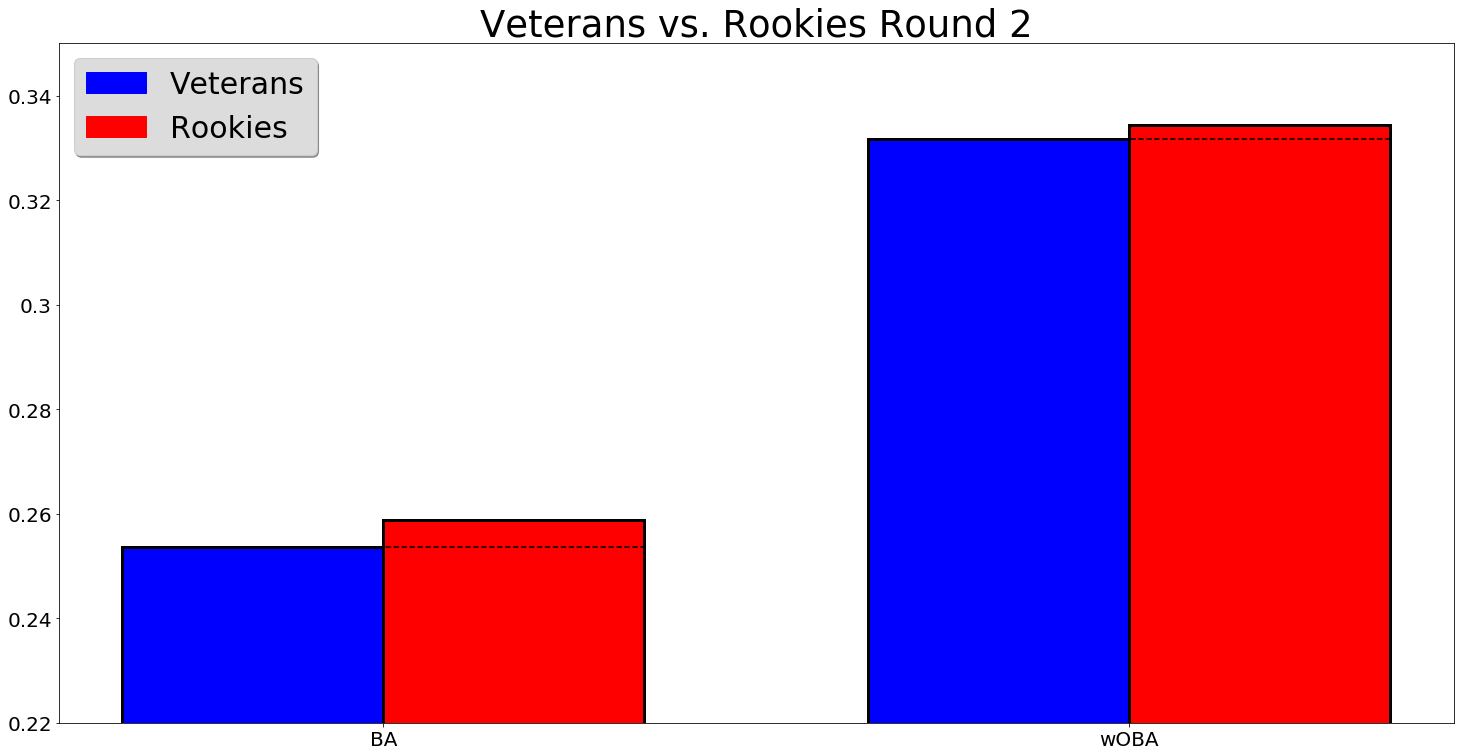

In [9]:
# Code Block 6 - Finish telling a story 

g2stats = ['BA', 'wOBA']

# Create lists of the average values for each statistic to be used in a barchart 
vetMeans = []
rokMeans = []
for stat in g2stats:
    vetMeans.append(veterans[stat].mean())
    rokMeans.append(rookies[stat].mean())

# Vizualize the chosen statistics side by side in order to compare Veterans against Rookies    
x = np.arange(len(g2stats))  
width = 0.35  
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, vetMeans, width, label='Veterans', color = 'blue', edgecolor = 'black', linewidth = 3)
rects2 = ax.bar(x + width/2, rokMeans, width, label='Rookies', color = 'red', edgecolor = 'black', linewidth = 3)

plt.title("Veterans vs. Rookies Round 2", size = 37)
ax.set_xticks(x)
ax.set_xticklabels(g2stats,size= 20)
plt.ylim(0.22, 0.35)
ax.set_yticklabels(labels = [0.22,0.24,0.26,0.28,0.30,0.32,0.34], size= 20)
plt.axhline(y=veterans['wOBA'].mean(), xmin = 0.7, xmax = 0.954, color = 'black', linestyle = '--' )
plt.axhline(y=veterans['BA'].mean(), xmin = 0.2, xmax = 0.42, color = 'black', linestyle = '--')
VET = mpatches.Patch(color='blue', label='Veterans')
ROK = mpatches.Patch(color='red', label='Rookies ')
plt.legend(handles=[VET, ROK], loc = 'upper left', fancybox = True, shadow = True, facecolor = 'gainsboro', prop={'size': 30})
